In [2]:
import torch
import geomstats as gm
from models.train import train, train_group
import numpy as np
!export GEOMSTATS_BACKEND=pytorch

INFO: Unable to initialize backend 'cuda': 
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
/home/abhijitbrahme/.conda/envs/approx-hmc/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


### Generate Data from Trajectories of Gaussian Distributions

The parameter space ($\mu$ , $\sigma$ ) of univariate gaussians can be modeled by the Poincare half-plane. Thus, geodesics between two univariate gaussians should follow geodesics corresponding to the Hyperboloid space.

In [2]:
from geomstats.information_geometry.normal import NormalDistributions
dim = 2
space = NormalDistributions(sample_dim=dim-1)
N = 10
time_steps = 20
t = torch.linspace(0,1,time_steps)
input_points = space.random_point(n_samples = N)
input_tangent_vec = space.random_tangent_vec(input_points)
geodesic = space.metric.geodesic(initial_point=input_points, initial_tangent_vec = input_tangent_vec)
geodesic_trajectories =  geodesic(t)

#### Plotting Trajectories

Text(0.5, 1.0, 'Geodesics of Univariate Gaussians')

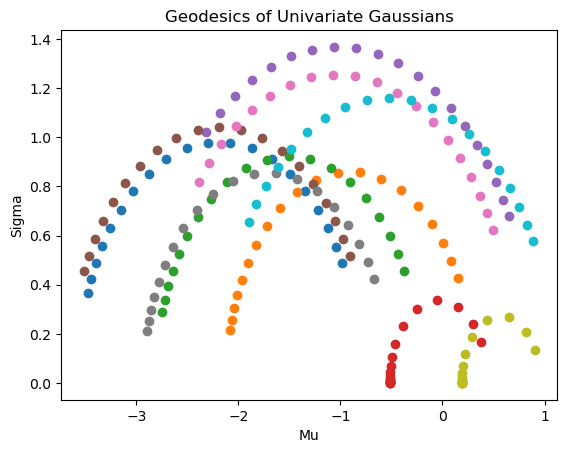

In [3]:
import matplotlib.pyplot as plt
for i in range(N):
    plt.scatter(geodesic_trajectories[i][:, 0], geodesic_trajectories[i][:, 1])
plt.xlabel("Mu")
plt.ylabel("Sigma")
plt.title("Geodesics of Univariate Gaussians")

### Train the Model

In [6]:
torch.set_default_dtype(torch.float32)
observed_trajectories = torch.from_numpy(geodesic_trajectories).to(torch.float32)
initial_conditions = torch.from_numpy(np.concatenate([input_points, input_tangent_vec], -1)).to(torch.float32)
model, preds = train(observed_trajectories, initial_conditions, val_initial_conditions=None, val_input_trajectories=None, epochs = 500, n = 2, t = time_steps, return_preds=True, val = False, model_type = "neural")

Epoch: 1, Loss: 0.7367276549339294, Val Loss: None
Epoch: 2, Loss: 0.5509227514266968, Val Loss: None
Epoch: 3, Loss: 0.3939095437526703, Val Loss: None
Epoch: 4, Loss: 0.25883549451828003, Val Loss: None
Epoch: 5, Loss: 0.1599959135055542, Val Loss: None
Epoch: 6, Loss: 0.11882781237363815, Val Loss: None
Epoch: 7, Loss: 0.14272341132164001, Val Loss: None
Epoch: 8, Loss: 0.17812742292881012, Val Loss: None
Epoch: 9, Loss: 0.17625102400779724, Val Loss: None
Epoch: 10, Loss: 0.1524200588464737, Val Loss: None
Epoch: 11, Loss: 0.12951986491680145, Val Loss: None
Epoch: 12, Loss: 0.11630582809448242, Val Loss: None
Epoch: 13, Loss: 0.11179698258638382, Val Loss: None
Epoch: 14, Loss: 0.11205607652664185, Val Loss: None
Epoch: 15, Loss: 0.11363185197114944, Val Loss: None
Epoch: 16, Loss: 0.11441001296043396, Val Loss: None
Epoch: 17, Loss: 0.11343301087617874, Val Loss: None
Epoch: 18, Loss: 0.11053545027971268, Val Loss: None
Epoch: 19, Loss: 0.10606022924184799, Val Loss: None
Epoch: 

In [7]:
model

RiemannianAutoencoder(
  (metric_space): NeuralRiemmanianMetric(
    (metric_function): PSD(
      (linear1): Linear(in_features=2, out_features=20, bias=True)
      (linear2): Linear(in_features=20, out_features=3, bias=True)
      (nonlinearity): Tanh()
    )
  )
  (ode_layer): NNODE(
    (odefunc): ODEFunc(
      (module): NeuralRiemmanianMetric(
        (metric_function): PSD(
          (linear1): Linear(in_features=2, out_features=20, bias=True)
          (linear2): Linear(in_features=20, out_features=3, bias=True)
          (nonlinearity): Tanh()
        )
      )
    )
    (neural_ode_layer): Neural ODE:
    	- order: 1        
    	- solver: DormandPrince45()
    	- adjoint solver: DormandPrince45()        
    	- tolerances: relative 0.001 absolute 0.001        
    	- adjoint tolerances: relative 0.0001 absolute 0.0001        
    	- num_parameters: 123        
    	- NFE: 200504.0
  )
)

#### Plotting the Training

Text(0.5, 1.0, 'Predicted Geodesics of Univariate Gaussians')

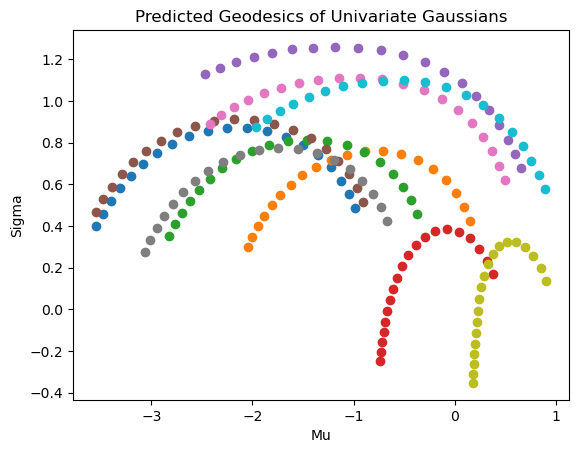

In [8]:
for i in range(N):
    plt.scatter(preds[-1][i][:, 0], preds[-1][i][:, 1])
plt.xlabel("Mu")
plt.ylabel("Sigma")
plt.title("Predicted Geodesics of Univariate Gaussians")

## Train an Equivariant Model 

#### Generate Data on a Circle

We are going to generate data on one half of a circle, and predict on the other half of the circle 

In [5]:
from geomstats.geometry.hypersphere import Hypersphere
dim = 2
space = Hypersphere(dim-1)
N = 10
time_steps = 20
t = torch.linspace(0,1,time_steps)

upper_hemisphere_input_theta = np.random.rand(N,1) * np.pi

input_points = np.concatenate([np.cos(upper_hemisphere_input_theta), np.sin(upper_hemisphere_input_theta)], -1)
input_tangent_vec = space.random_tangent_vec(input_points)
geodesic = space.metric.geodesic(initial_point=input_points, initial_tangent_vec = input_tangent_vec)
geodesic_trajectories =  geodesic(t)

#### Plotting Trajectories

Text(0.5, 1.0, 'Geodesics on Half Circles')

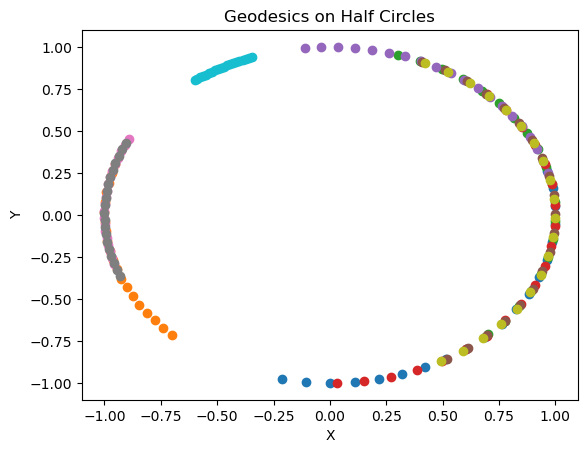

In [6]:
import matplotlib.pyplot as plt
for i in range(N):
    plt.scatter(geodesic_trajectories[i][:, 0], geodesic_trajectories[i][:, 1])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Geodesics on Half Circles")

### Train the Model

In this model, we have to define the input representation, the output representation, and the Group we wish to be equivariant to. Let's say we want to be equivariant to $SO(2)$. Unsure about the workings of this package, but I think input representation and output representation are the spaces (vectors) and their dimensions. 

In [18]:
##### TODO